In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Loading sets
sales = pd.read_csv("D:\m5_demand_forecasting_project\data_raw\sales_train_validation.csv")
calendar = pd.read_csv("D:\m5_demand_forecasting_project\data_raw\calendar.csv")

# Melting sales: wide to long
sales_long = pd.melt(
    sales,
    id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
    var_name='d',
    value_name='sales'
)

# Merging with calendar to get dates
sales_long = sales_long.merge(calendar[['d', 'date']], on='d', how='left')
sales_long['date'] = pd.to_datetime(sales_long['date'])

# Preview
print(sales_long.head())

                              id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id    d  sales       date  
0       CA  d_1      0 2011-01-29  
1       CA  d_1      0 2011-01-29  
2       CA  d_1      0 2011-01-29  
3       CA  d_1      0 2011-01-29  
4       CA  d_1      0 2011-01-29  


---
**Key Findings:** 

Reshaped from wide to long format for time-series operations. Each row now represents a single SKU-store-date record.

---

In [2]:
# Adding 'week' and 'year' columns
sales_long['week'] = sales_long['date'].dt.isocalendar().week
sales_long['year'] = sales_long['date'].dt.isocalendar().year

# Combining into 'year_week' identifier
sales_long['year_week'] = sales_long['year'].astype(str) + '-' + sales_long['week'].astype(str).str.zfill(2)

# ing by SKU + store + week
weekly_sales = sales_long.groupby(
    ['store_id', 'item_id', 'year_week']
)['sales'].sum().reset_index()

# Saving to outputs
weekly_sales.to_csv("D:\m5_demand_forecasting_project\outputs\weekly_sales.csv", index=False)

# Preview
print(weekly_sales.head())

  store_id      item_id year_week  sales
0     CA_1  FOODS_1_001   2011-04      3
1     CA_1  FOODS_1_001   2011-05      9
2     CA_1  FOODS_1_001   2011-06      7
3     CA_1  FOODS_1_001   2011-07     10
4     CA_1  FOODS_1_001   2011-08     14


---
**Key Findings:** 

Weekly aggregation reduces noise and aligns with business cycles. Data is now structured for rolling windows and lag analysis.

---

In [3]:
# Top 10 High-Volume SKUs
top_skus = weekly_sales.groupby('item_id')['sales'].sum().sort_values(ascending=False).head(10)
print(top_skus)

item_id
FOODS_3_090    1002529
FOODS_3_586     920242
FOODS_3_252     565299
FOODS_3_555     491287
FOODS_3_714     396172
FOODS_3_587     396119
FOODS_3_694     390001
FOODS_3_226     363082
FOODS_3_202     295689
FOODS_3_723     284333
Name: sales, dtype: int64


---
**Key Findings:** 

1. Weekly aggregation reduces noise and aligns with business cycles. Data is now structured for rolling windows and lag analysis.
2. Top SKUs are mostly in the FOODS category, indicating that perishable and fast-moving goods dominate demand. High-volume SKUs will be prioritized for modeling to ensure strong signal behavior.
---

In [4]:
# Top 5 Highest-Volume Stores
top_stores = weekly_sales.groupby('store_id')['sales'].sum().sort_values(ascending=False)
print(top_stores)

store_id
CA_3    11188180
CA_1     7698216
TX_2     7214384
WI_2     6544012
WI_3     6427782
TX_3     6089330
CA_2     5685475
TX_1     5595292
WI_1     5149062
CA_4     4103676
Name: sales, dtype: int64


---
**Key Findings:** 

Weekly aggregation reduces noise and aligns with business cycles. Data is now structured for rolling windows and lag analysis.

---

In [5]:
# Most Volatile SKUs (Standard Deviation of Sales)
volatile_skus = weekly_sales.groupby('item_id')['sales'].std().sort_values(ascending=False).head(10)
print(volatile_skus)

item_id
FOODS_3_090    374.633777
FOODS_3_586    209.603008
FOODS_3_120    157.003553
FOODS_3_252    133.110804
FOODS_3_318    121.764293
FOODS_3_226    121.380962
FOODS_3_635    119.897259
FOODS_3_541    118.902663
FOODS_3_808    116.733450
FOODS_3_587    116.653746
Name: sales, dtype: float64


---
**Key Findings:** 
1. Weekly aggregation reduces noise and aligns with business cycles. Data is now structured for rolling windows and lag analysis.
2. Top SKUs are mostly in the FOODS category, indicating that perishable and fast-moving goods dominate demand. High-volume SKUs will be prioritized for modeling to ensure strong signal behavior.
3. High standard deviation in certain SKUs suggests promotion-driven or erratic demand, highlighting the need for event-based features in modeling.
---

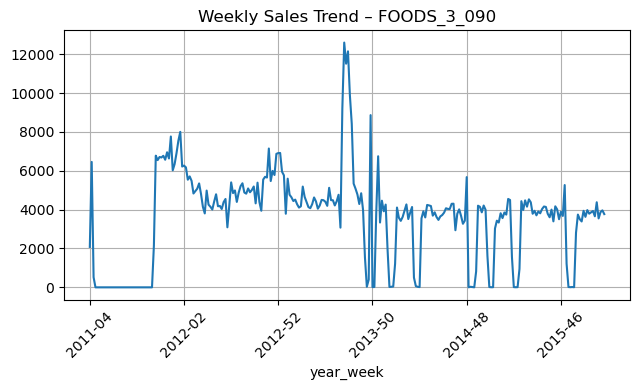

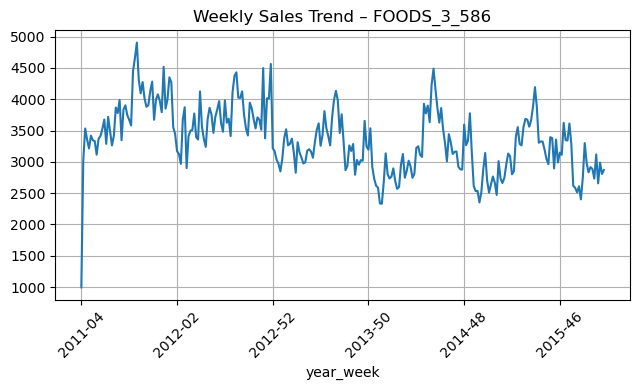

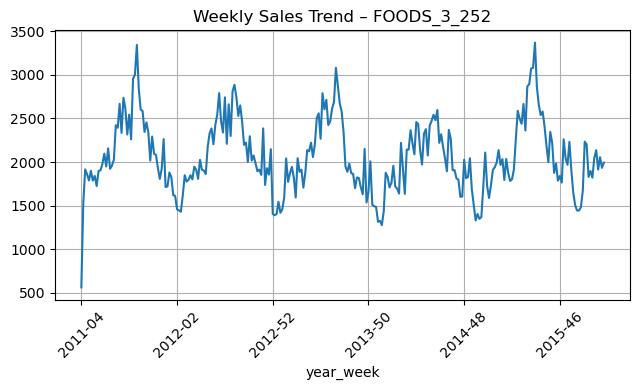

In [17]:
# Weekly sales trend of top 3 SKUs
top_3_skus = top_skus.index[:3]

for sku in top_3_skus:
    sku_df = weekly_sales[weekly_sales['item_id'] == sku]
    sku_grouped = sku_df.groupby('year_week')['sales'].sum()
    
    plt.figure(figsize=(6.5, 4))
    sku_grouped.plot()
    plt.title(f"Weekly Sales Trend – {sku}")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

---
**Key Findings:** 

1. Weekly aggregation reduces noise and aligns with business cycles. Data is now structured for rolling windows and lag analysis.
2. Clear weekly seasonality patterns are visible, especially around holiday weeks, validating the inclusion of event/holiday flags in our feature set.
---

In [7]:
# Loading and merging calendar data
calendar = pd.read_csv("D:\m5_demand_forecasting_project\data_raw\calendar.csv")

# Keeping important columns
calendar = calendar[['date', 'd', 'weekday', 'wday', 'month', 'year', 'event_name_1', 'snap_CA', 'snap_TX', 'snap_WI']]

# Converting to categorical 
calendar['event_name_1'] = calendar['event_name_1'].fillna('None')

# Encoding event as binary flag
calendar['is_event'] = (calendar['event_name_1'] != 'None').astype(int)

In [8]:
# Adding time features
weekly_sales = pd.read_csv("D:\m5_demand_forecasting_project\outputs\weekly_sales.csv")
weekly_sales['year'] = weekly_sales['year_week'].str[:4].astype(int)
weekly_sales['week'] = weekly_sales['year_week'].str[5:].astype(int)

# Adding month/season approximation using mapping
month_map = calendar[['date', 'year', 'month']].drop_duplicates()

calendar_weeks = calendar.copy()
calendar_weeks['date'] = pd.to_datetime(calendar_weeks['date'])
calendar_weeks['week'] = calendar_weeks['date'].dt.isocalendar().week
calendar_weeks['year_week'] = calendar_weeks['year'].astype(str) + '-' + calendar_weeks['week'].astype(str).str.zfill(2)

# Aggregating event/snap at weekly level
calendar_weekly = calendar_weeks.groupby(['year_week']).agg({
    'is_event': 'max',
    'snap_CA': 'max',
    'month': 'median'
}).reset_index()

# Merging into weekly_sales
weekly_sales = weekly_sales.merge(calendar_weekly, on='year_week', how='left')

---
**Key Findings:** 

Weekly aggregation reduces noise and aligns with business cycles. Data is now structured for rolling windows and lag analysis.

---

In [9]:
# Sorting data
weekly_sales = weekly_sales.sort_values(by=['store_id', 'item_id', 'year_week'])

# Initiaing Lag features
weekly_sales['lag_1'] = weekly_sales.groupby(['store_id', 'item_id'])['sales'].shift(1)
weekly_sales['lag_4'] = weekly_sales.groupby(['store_id', 'item_id'])['sales'].shift(4)

# Initating Rolling average (4-week)
weekly_sales['rolling_mean_4'] = (
    weekly_sales.groupby(['store_id', 'item_id'])['sales']
    .shift(1)
    .rolling(window=4)
    .mean()
)

---
**Key Findings:** 

Weekly aggregation reduces noise and aligns with business cycles. Data is now structured for rolling windows and lag analysis.

---

In [10]:
# Saving to outputs
weekly_sales.to_csv("D:\m5_demand_forecasting_project\outputs\weekly_sales.csv", index=False)

---
**Notebook Summary:** 

This notebook establishes a cleaned, weekly-aligned dataset with feature-rich structure (time identifiers, event flags, and lag/rolling features). It is fully rerunnable and ready for the modeling phase.

---